In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyearth import Earth
%matplotlib inline

### Conclusions

Logistic (2500 iters): f1-score \[0.50000 0.58915 0.44660 0.27957\] average **0.45383**

LinearSVC (2500 iters): f1-score \[0.46053 0.55556 0.31148 0.28947\] average 0.40426

Linear Regressor: f1-score \[0.50400 0.59160 0.44843 0.25974\] average 0.45094

LinearSVR (C=0.5, loss='squared_epsilon_insensitive'): f1-score \[0.46120 0.60486 0.42365 0.28571\] average 0.44385

KNN Regressor (weights='distance', n_neighbors=16): f1-score \[0.46454 0.45152 0.28647 0.21374\] average 0.35407

SVR + PolynomialCountSketch (degree=3, n_components=300): f1-score \[0.44358 0.55508 0.37419 0.26087\] average 0.40843

SVR + Nystroem (degree=3): f1-score \[0.51410 0.59402 0.37879 0.21176\] average 0.42467

SplineTransformer + SVR + Nystroem (degree=3): f1-score \[0.54518 0.58932 0.35965 0.24242\] average 0.43414

MARS (degree=3, max_terms=500): f1-score \[0.46120 0.60814 0.46988 0.26667\] average 0.45147

In [2]:
# read Dataset as Pandas DataFrame
print("================ Reading dataset ===============")
dataset = pd.read_pickle('../Dataset/baseline_dataset_ts_24.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

================ Reading dataset ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 54 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LOW_IMPACT     45293 non-null  bool   
 1   MID_IMPACT     45293 non-null  bool   
 2   BIG_IMPACT     45293 non-null  bool   
 3   DIRECT_STRIKE  45293 non-null  bool   
 4   MM00           45293 non-null  int32  
 5   DD00           45293 non-null  int32  
 6   HH00           45293 non-null  int32  
 7   MI_STATUS00    45293 non-null  bool   
 8   LI_STATUS00    45293 non-null  bool   
 9   SI_STATUS00    45293 non-null  bool   
 10  DS_STATUS00    45293 non-null  bool   
 11  LAT00          45293 non-null  float32
 12  LON00          45293 non-null  float32
 13  VMAX00         45293 non-null  int32  
 14  MM06           45293 non-null  int32  
 15  DD06           45293 non-null  int32  
 16  HH06           45293 non-null  int32  
 17  M

In [3]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

# Constants
TRAIN_RATIO = 0.9

In [4]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,0:4]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36686; Dev set size: 4077; Testing set size: 4530


### Tools

In [5]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [6]:
# new utility functions
from scipy.special import expit

def regression_predict(regr, datasetX, method='sigmoid'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='sigmoid'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='sigmoid'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

### Solid proof that PCA and Poly features don't always work

In [7]:
# imports
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem, PolynomialCountSketch
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [8]:
poly = PolynomialFeatures(degree=3, include_bias=False)
transformed_X = poly.fit_transform(train_X)

transformed_X.shape

(36686, 23425)

In [9]:
std_X = StandardScaler().fit(transformed_X)
standard_X = std_X.transform(transformed_X)
pca = PCA(n_components=450)
pca.fit(standard_X)

MemoryError: Unable to allocate 13.0 GiB for an array with shape (36317, 47904) and data type float64

### Classifiers

In [9]:
basic_clf_1 = OneVsRestClassifier(LogisticRegression(
    max_iter=2500
), n_jobs=-1)

basic_clf_1 = basic_clf_1.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_1.predict(train_X))))

# test model on dev set
preds = basic_clf_1.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0))

Training accuracy: 0.9104017881
Accuracy of classifier on dev set: 0.9141525632
              precision    recall  f1-score   support

           0       0.93      0.30      0.46       347
           1       0.82      0.44      0.57       271
           2       0.86      0.18      0.30       103
           3       0.85      0.17      0.28        65

   micro avg       0.87      0.32      0.47       786
   macro avg       0.86      0.27      0.40       786
weighted avg       0.88      0.32      0.46       786
 samples avg       0.05      0.04      0.04       786



/tmp/.u3556490/ipykernel_19499/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.97179, F-Score=0.46053
Best Threshold=0.32920, F-Score=0.60927
Best Threshold=0.19679, F-Score=0.45455
Best Threshold=0.75779, F-Score=0.28947


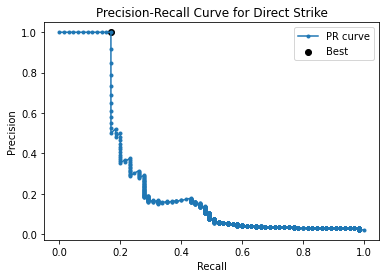

In [10]:
best_thresholds, best_f1_scores = optimize_thresholds(basic_clf_1, dev_X, dev_Y)

In [11]:
preds = predictions_with_thresholds(basic_clf_1, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.96296   0.29971   0.45714       347
           1    0.75691   0.50554   0.60619       271
           2    0.42241   0.47573   0.44749       103
           3    1.00000   0.15385   0.26667        65

   micro avg    0.72289   0.38168   0.49958       786
   macro avg    0.78557   0.35871   0.44437       786
weighted avg    0.82415   0.38168   0.49152       786
 samples avg    0.04035   0.04550   0.04083       786



In [13]:
from sklearn.svm import LinearSVC

basic_clf_2 = OneVsRestClassifier(LinearSVC(dual=False, max_iter=2500), n_jobs=-1)

basic_clf_2 = basic_clf_2.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_2.predict(train_X))))

# test model on dev set
preds = basic_clf_2.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Training accuracy: 0.9106471133
Accuracy of classifier on dev set: 0.9139072848
              precision    recall  f1-score   support

           0    0.96330   0.30259   0.46053       347
           1    0.80420   0.42435   0.55556       271
           2    1.00000   0.18447   0.31148       103
           3    1.00000   0.16923   0.28947        65

   micro avg    0.88652   0.31807   0.46816       786
   macro avg    0.94187   0.27016   0.40426       786
weighted avg    0.91629   0.31807   0.45961       786
 samples avg    0.04742   0.04110   0.04202       786



### Regressors

In [14]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

linear_regr = MultiOutputRegressor(LinearRegression(), n_jobs=-1)
linear_regr = linear_regr.fit(train_X, train_Y)

Best Threshold=0.70193, F-Score=0.46460
Best Threshold=0.59900, F-Score=0.61062
Best Threshold=0.55366, F-Score=0.46083
Best Threshold=0.71504, F-Score=0.28947


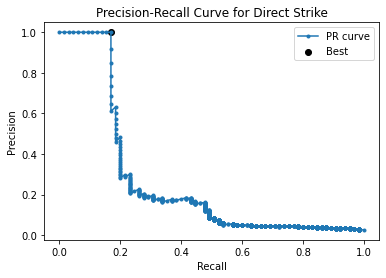

In [15]:
best_thresholds, best_f1_scores = regressor_find_thresholds(linear_regr, dev_X, dev_Y, 'sigmoid')

In [16]:
preds = regression_label(linear_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.29971   0.46120       347
           1    0.76111   0.50554   0.60754       271
           2    0.43363   0.47573   0.45370       103
           3    1.00000   0.15385   0.26667        65

   micro avg    0.73710   0.38168   0.50293       786
   macro avg    0.79868   0.35871   0.44728       786
weighted avg    0.84342   0.38168   0.49458       786
 samples avg    0.03982   0.04552   0.04050       786



In [17]:
from sklearn.svm import LinearSVR

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

svr_regr = svr_regr.fit(train_X, train_Y)

Best Threshold=0.70843, F-Score=0.46460
Best Threshold=0.59823, F-Score=0.60793
Best Threshold=0.55398, F-Score=0.43137
Best Threshold=0.53950, F-Score=0.30769


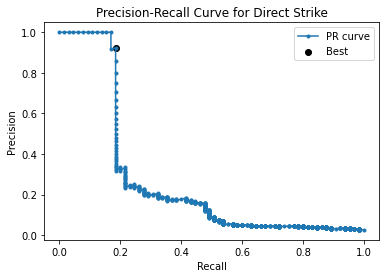

In [18]:
best_thresholds, best_f1_scores = regressor_find_thresholds(svr_regr, dev_X, dev_Y, 'sigmoid')

In [19]:
preds = regression_label(svr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.29971   0.46120       347
           1    0.75275   0.50554   0.60486       271
           2    0.43000   0.41748   0.42365       103
           3    0.91667   0.16923   0.28571        65

   micro avg    0.74121   0.37532   0.49831       786
   macro avg    0.77485   0.34799   0.44385       786
weighted avg    0.83317   0.37532   0.49130       786
 samples avg    0.04006   0.04532   0.04046       786



In [29]:
from sklearn.neighbors import KNeighborsRegressor

knr_regr = MultiOutputRegressor(KNeighborsRegressor(weights='distance', n_neighbors=16), n_jobs=-1)

knr_regr = knr_regr.fit(train_X, train_Y)

Best Threshold=0.56515, F-Score=0.46612
Best Threshold=0.56239, F-Score=0.45367
Best Threshold=0.53565, F-Score=0.29101
Best Threshold=0.54681, F-Score=0.22727


/tmp/.u3556490/ipykernel_19499/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_19499/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


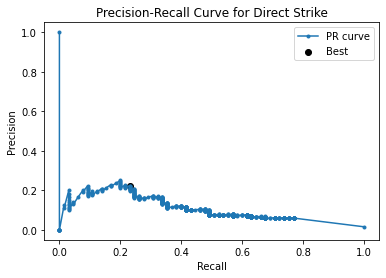

In [30]:
best_thresholds, best_f1_scores = regressor_find_thresholds(knr_regr, dev_X, dev_Y, 'sigmoid')

In [31]:
preds = regression_label(knr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.36102   0.65130   0.46454       347
           1    0.36142   0.60148   0.45152       271
           2    0.19708   0.52427   0.28647       103
           3    0.21212   0.21538   0.21374        65

   micro avg    0.32251   0.58142   0.41489       786
   macro avg    0.28291   0.49811   0.35407       786
weighted avg    0.32736   0.58142   0.41598       786
 samples avg    0.05770   0.06555   0.05667       786



In [49]:
from sklearn.preprocessing import SplineTransformer

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

pipe = make_pipeline(
    SplineTransformer(include_bias=False),
    # PolynomialFeatures(),
    StandardScaler(),
    Nystroem(kernel='poly', degree=3),
    # PolynomialCountSketch(degree=3, n_components=300),
    svr_regr, verbose=True
)
print(pipe)

poly_svr_regr = pipe.fit(train_X, train_Y)

Pipeline(steps=[('splinetransformer', SplineTransformer(include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('nystroem', Nystroem(degree=3, kernel='poly')),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.5, dual=False,
                                                          loss='squared_epsilon_insensitive'),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] . (step 1 of 4) Processing splinetransformer, total=   0.8s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.2s
[Pipeline] .......... (step 3 of 4) Processing nystroem, total=   0.4s
[Pipeline]  (step 4 of 4) Processing multioutputregressor, total=   3.9s


Best Threshold=0.57020, F-Score=0.54737
Best Threshold=0.55587, F-Score=0.59191
Best Threshold=0.55185, F-Score=0.36681
Best Threshold=0.54540, F-Score=0.26000


/tmp/.u3556490/ipykernel_19499/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


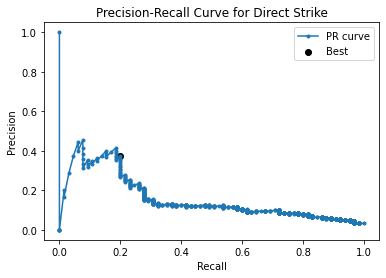

In [50]:
best_thresholds, best_f1_scores = regressor_find_thresholds(poly_svr_regr, dev_X, dev_Y, 'sigmoid')

In [51]:
preds = regression_label(poly_svr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.57098   0.52161   0.54518       347
           1    0.58824   0.59041   0.58932       271
           2    0.32800   0.39806   0.35965       103
           3    0.35294   0.18462   0.24242        65

   micro avg    0.52674   0.50127   0.51369       786
   macro avg    0.46004   0.42367   0.43414       786
weighted avg    0.52706   0.50127   0.51105       786
 samples avg    0.05032   0.05897   0.05068       786



/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

### Ultimate weapon: Regression splines
#### MARS

In [40]:
earth_regr = MultiOutputRegressor(Earth(max_degree=3, max_terms=500, use_fast=True), n_jobs=-1)
earth_regr = earth_regr.fit(train_X, train_Y)

Best Threshold=0.71765, F-Score=0.46460
Best Threshold=0.61159, F-Score=0.61111
Best Threshold=0.58190, F-Score=0.47904
Best Threshold=0.72847, F-Score=0.28947


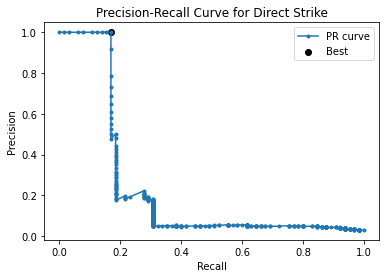

In [41]:
best_thresholds, best_f1_scores = regressor_find_thresholds(earth_regr, dev_X, dev_Y, 'sigmoid')

In [42]:
preds = regression_label(earth_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.29971   0.46120       347
           1    0.72449   0.52399   0.60814       271
           2    0.61905   0.37864   0.46988       103
           3    1.00000   0.15385   0.26667        65

   micro avg    0.79088   0.37532   0.50906       786
   macro avg    0.83588   0.33905   0.45147       786
weighted avg    0.85509   0.37532   0.49691       786
 samples avg    0.04133   0.04529   0.04128       786

